# Preparation for modeling
In this notebook, we make our data to be prepared for not only being suitable for ML techniques but also generating good performance.

In [1]:
import pandas as pd
from warnings import simplefilter
from tqdm import tqdm
import datetime
import numpy as np
simplefilter(action="ignore", category=pd.errors.DtypeWarning)
pd.set_option('display.max_columns', None)

import pickle

## data crop and labeling

in this section, we label the prediction targets with 30 diffrent versions. 

the type of prediction targets varies by prediction window(6), data crop(4+1)

This section contains:
1. cohort selection, which can be abbreviated as SCR
2. labeling considering data crop and windows 

In [2]:
def labeling(df, target_name='SHOCK', windows=[1,2,3,4,5,6], data_crops=[0,1,2,3,4,5,6,12,999]):
    target = df[target_name]

    if sum(target) == 0: # nonshock stay
        for dc, pw in [(i, j) for i in data_crops for j in windows]:
            df[str('%s_dc%d_pw%s' %(target_name.lower(), dc, pw))] = 0

        return df
    
    shock_onset = target.tolist().index(1)
    for dc, pw in [(i, j) for i in data_crops for j in windows]:
        if dc != 999:
            target_cropped = target[:shock_onset+1+dc].tolist() + [np.nan for _ in range(len(target)-(shock_onset+1+dc))]
            target_cropped = pd.Series(target_cropped)
        else:
            target_cropped = target
        
        tmp = pd.Series([0 for _ in range(len(target))])
        for i in range(1, pw+1):
            tmp += target_cropped.shift(-i)
        
        label = [np.nan if pd.isna(i) else 1 if i>0 else 0 for i in tmp]

        df[str('%s_dc%d_pw%s' %(target_name.lower(), dc, pw))] = label
    
    return df
        # when training model with this labeling scheme, one should consider 1) drop the nan having rows, 2) drop the stay that has only nan labels.

In [3]:
with open('sepsis_tabdata_raw.pkl','rb') as f:
    tab_data = pickle.load(f)

icustays = pd.read_csv('processed_data/sepsis/icustays_tab_1hr_v1.csv')
icustays = icustays.loc[icustays.cohort_stays_tab_1hr_v1 == 1].reset_index(drop=True)
stayids = icustays.stay_id.unique()
icustays.intime = pd.to_datetime(icustays.intime)
icustays.outtime = pd.to_datetime(icustays.outtime)

In [4]:
sepsis_data_tab1_v1_SCRL = {}
for i in tqdm(range(len(stayids))):
    tmp_stay = stayids[i]
    tmp_cond = icustays.stay_id == tmp_stay
    tmp_adm = icustays.loc[tmp_cond].hadm_id.tolist()[0]
    it, ot = icustays.loc[tmp_cond, ('intime', 'outtime')].reset_index(drop=True).loc[0]
    tmp_adm_data = tab_data[tmp_adm]	
    tmp_cond = (tmp_adm_data.seq_ET >= it) & (tmp_adm_data.seq_ST <= ot)
    tmp_stay_df = tmp_adm_data.loc[tmp_cond].reset_index(drop=True)

    # SCR and labeling
    sepsis_data_tab1_v1_SCRL[tmp_stay] = labeling(tmp_stay_df)

100%|██████████| 11780/11780 [04:32<00:00, 43.17it/s]


In [5]:
with open('sepsis_data_tab1_v1_SCRL.pkl','wb') as f:
    pickle.dump(sepsis_data_tab1_v1_SCRL, f)

## feature engineering
in this section, feature engineering, especially meta variable addition, is defined by functions and some of the variables known to be helpful to show good performances will be calculated and added.

the variables that will be manipulated to generate meta variabes are defined as the first cell.

In [6]:
core_features = ['sbp', 'dbp', 'map', 'pao2', 'fio2', 'lactate', 'arterial_ph', 'gcs', 'creatinine', 'bilirubin', 'platelets']

slope_features = [i+str('_slp%d' %j) for i in core_features for j in [1, 3, 5]]

In [7]:
with open('sepsis_data_tab1_v1_SCRL.pkl','rb') as f:
    sepsis_data_tab1_v1_SCRL = pickle.load(f)
stayids = list(sepsis_data_tab1_v1_SCRL.keys())

In [8]:
for tmp_stay in tqdm(stayids):
    tmp_stay_df = sepsis_data_tab1_v1_SCRL[tmp_stay]

    for fn in core_features:
        for slp in [1, 3, 5]:
            tmp_stay_df[str('%s_slp%d' %(fn, slp))] = tmp_stay_df[str('%s_value' %(fn))] - tmp_stay_df[str('%s_value' %(fn))].shift(slp).fillna(method='bfill').fillna(0)
    
    sepsis_data_tab1_v1_SCRL[tmp_stay] = tmp_stay_df

100%|██████████| 11780/11780 [02:33<00:00, 76.63it/s]


In [9]:
with open('sepsis_data_tab1_v1_FE.pkl','wb') as f:
    pickle.dump(sepsis_data_tab1_v1_SCRL, f)

## make dataframe

In [10]:
def make_df(data, id_list, id_type='stay_id'):
    df_list = []    
    for id in tqdm(id_list):
        data[id][id_type] = id
        df_list += data[id].values.tolist()
    df = pd.DataFrame(df_list, columns=data[id].columns)

    return df

In [11]:
with open('sepsis_data_tab1_v1_FE.pkl','rb') as f:
    sepsis_data_tab1_v1_FE = pickle.load(f)
stayids = list(sepsis_data_tab1_v1_FE.keys())

In [12]:
sepsis_data_t1v1FE_df = make_df(sepsis_data_tab1_v1_FE, stayids)

100%|██████████| 11780/11780 [01:32<00:00, 127.66it/s]


In [13]:
sepsis_data_t1v1FE_df.iloc[0:10, [0,1,2,3,-4,-3,-2,-1]]

,hadm_id,seq_num,seq_ST,seq_ET,platelets_slp1,platelets_slp3,platelets_slp5,stay_id
0,26184834,76,2131-01-11 03:59:59,2131-01-11 04:59:59,0.0,0.0,0.0,37510196
1,26184834,77,2131-01-11 04:59:59,2131-01-11 05:59:59,0.0,0.0,0.0,37510196
2,26184834,78,2131-01-11 05:59:59,2131-01-11 06:59:59,-47.0,-47.0,-47.0,37510196
3,26184834,79,2131-01-11 06:59:59,2131-01-11 07:59:59,0.0,-47.0,-47.0,37510196
4,26184834,80,2131-01-11 07:59:59,2131-01-11 08:59:59,0.0,-47.0,-47.0,37510196
5,26184834,81,2131-01-11 08:59:59,2131-01-11 09:59:59,0.0,0.0,-47.0,37510196
6,26184834,82,2131-01-11 09:59:59,2131-01-11 10:59:59,0.0,0.0,-47.0,37510196
7,26184834,83,2131-01-11 10:59:59,2131-01-11 11:59:59,0.0,0.0,0.0,37510196
8,26184834,84,2131-01-11 11:59:59,2131-01-11 12:59:59,0.0,0.0,0.0,37510196
9,26184834,85,2131-01-11 12:59:59,2131-01-11 13:59:59,0.0,0.0,0.0,37510196


In [14]:
sepsis_data_tab1_v1_FE[stayids[0]].iloc[0:10, [0,1,2,3,-3,-2,-1]]

,hadm_id,seq_num,seq_ST,seq_ET,platelets_slp3,platelets_slp5,stay_id
0,26184834,76,2131-01-11 03:59:59,2131-01-11 04:59:59,0.0,0.0,37510196
1,26184834,77,2131-01-11 04:59:59,2131-01-11 05:59:59,0.0,0.0,37510196
2,26184834,78,2131-01-11 05:59:59,2131-01-11 06:59:59,-47.0,-47.0,37510196
3,26184834,79,2131-01-11 06:59:59,2131-01-11 07:59:59,-47.0,-47.0,37510196
4,26184834,80,2131-01-11 07:59:59,2131-01-11 08:59:59,-47.0,-47.0,37510196
5,26184834,81,2131-01-11 08:59:59,2131-01-11 09:59:59,0.0,-47.0,37510196
6,26184834,82,2131-01-11 09:59:59,2131-01-11 10:59:59,0.0,-47.0,37510196
7,26184834,83,2131-01-11 10:59:59,2131-01-11 11:59:59,0.0,0.0,37510196
8,26184834,84,2131-01-11 11:59:59,2131-01-11 12:59:59,0.0,0.0,37510196
9,26184834,85,2131-01-11 12:59:59,2131-01-11 13:59:59,0.0,0.0,37510196


In [15]:
sepsis_data_t1v1FE_df.to_csv('sepsis_data_t1v1FE_df.csv', index=False)

## version 2. with cvp

### data crop and labeling

in this section, we label the prediction targets with 30 diffrent versions. 

the type of prediction targets varies by prediction window(6), data crop(4+1)

This section contains:
1. cohort selection, which can be abbreviated as SCR
2. labeling considering data crop and windows 

In [2]:
def labeling(df, target_name='SHOCK', windows=[1,2,3,4,5,6], data_crops=[0,1,2,3,4,5,6,12,999]):
    target = df[target_name]

    if sum(target) == 0: # nonshock stay
        for dc, pw in [(i, j) for i in data_crops for j in windows]:
            df[str('%s_dc%d_pw%s' %(target_name.lower(), dc, pw))] = 0

        return df
    
    shock_onset = target.tolist().index(1)
    for dc, pw in [(i, j) for i in data_crops for j in windows]:
        if dc != 999:
            target_cropped = target[:shock_onset+1+dc].tolist() + [np.nan for _ in range(len(target)-(shock_onset+1+dc))]
            target_cropped = pd.Series(target_cropped)
        else:
            target_cropped = target
        
        tmp = pd.Series([0 for _ in range(len(target))])
        for i in range(1, pw+1):
            tmp += target_cropped.shift(-i)
        
        label = [np.nan if pd.isna(i) else 1 if i>0 else 0 for i in tmp]

        df[str('%s_dc%d_pw%s' %(target_name.lower(), dc, pw))] = label
    
    return df
        # when training model with this labeling scheme, one should consider 1) drop the nan having rows, 2) drop the stay that has only nan labels.

In [3]:
with open('sepsis_tabdata_raw_v2.pkl','rb') as f:
    tab_data = pickle.load(f)

icustays = pd.read_csv('processed_data/sepsis/icustays_tab_1hr_v1.csv')
icustays = icustays.loc[icustays.cohort_stays_tab_1hr_v1 == 1].reset_index(drop=True)
stayids = icustays.stay_id.unique()
icustays.intime = pd.to_datetime(icustays.intime)
icustays.outtime = pd.to_datetime(icustays.outtime)

In [4]:
sepsis_data_tab1_v2_SCRL = {}
for i in tqdm(range(len(stayids))):
    tmp_stay = stayids[i]
    tmp_cond = icustays.stay_id == tmp_stay
    tmp_adm = icustays.loc[tmp_cond].hadm_id.tolist()[0]
    it, ot = icustays.loc[tmp_cond, ('intime', 'outtime')].reset_index(drop=True).loc[0]
    tmp_adm_data = tab_data[tmp_adm]	
    tmp_cond = (tmp_adm_data.seq_ET >= it) & (tmp_adm_data.seq_ST <= ot)
    tmp_stay_df = tmp_adm_data.loc[tmp_cond].reset_index(drop=True)

    # SCR and labeling
    sepsis_data_tab1_v2_SCRL[tmp_stay] = labeling(tmp_stay_df)

100%|██████████| 11780/11780 [04:34<00:00, 42.89it/s]


In [5]:
with open('sepsis_data_tab1_v2_SCRL.pkl','wb') as f:
    pickle.dump(sepsis_data_tab1_v2_SCRL, f)

### feature engineering
in this section, feature engineering, especially meta variable addition, is defined by functions and some of the variables known to be helpful to show good performances will be calculated and added.

the variables that will be manipulated to generate meta variabes are defined as the first cell.

In [6]:
core_features = ['sbp', 'dbp', 'map', 'pao2', 'fio2', 'lactate', 'arterial_ph', 'gcs', 'creatinine', 'bilirubin', 'platelets']

slope_features = [i+str('_slp%d' %j) for i in core_features for j in [1, 3, 5]]

In [8]:
with open('sepsis_data_tab1_v2_SCRL.pkl','rb') as f:
    sepsis_data_tab1_v2_SCRL = pickle.load(f)
stayids = list(sepsis_data_tab1_v2_SCRL.keys())

In [9]:
for tmp_stay in tqdm(stayids):
    tmp_stay_df = sepsis_data_tab1_v2_SCRL[tmp_stay]

    for fn in core_features:
        for slp in [1, 3, 5]:
            tmp_stay_df[str('%s_slp%d' %(fn, slp))] = tmp_stay_df[str('%s_value' %(fn))] - tmp_stay_df[str('%s_value' %(fn))].shift(slp).fillna(method='bfill').fillna(0)
    
    sepsis_data_tab1_v2_SCRL[tmp_stay] = tmp_stay_df

100%|██████████| 11780/11780 [02:32<00:00, 77.44it/s]


In [10]:
with open('sepsis_data_tab1_v2_FE.pkl','wb') as f:
    pickle.dump(sepsis_data_tab1_v2_SCRL, f)

### make dataframe

In [11]:
def make_df(data, id_list, id_type='stay_id'):
    df_list = []    
    for id in tqdm(id_list):
        data[id][id_type] = id
        df_list += data[id].values.tolist()
    df = pd.DataFrame(df_list, columns=data[id].columns)

    return df

In [12]:
with open('sepsis_data_tab1_v2_FE.pkl','rb') as f:
    sepsis_data_tab1_v2_FE = pickle.load(f)
stayids = list(sepsis_data_tab1_v2_FE.keys())

In [13]:
sepsis_data_t1v2FE_df = make_df(sepsis_data_tab1_v2_FE, stayids)

100%|██████████| 11780/11780 [01:49<00:00, 107.29it/s]


In [14]:
sepsis_data_t1v2FE_df.iloc[0:10, [0,1,2,3,-4,-3,-2,-1]]

,hadm_id,seq_num,seq_ST,seq_ET,platelets_slp1,platelets_slp3,platelets_slp5,stay_id
0,26184834,76,2131-01-11 03:59:59,2131-01-11 04:59:59,0.0,0.0,0.0,37510196
1,26184834,77,2131-01-11 04:59:59,2131-01-11 05:59:59,0.0,0.0,0.0,37510196
2,26184834,78,2131-01-11 05:59:59,2131-01-11 06:59:59,-47.0,-47.0,-47.0,37510196
3,26184834,79,2131-01-11 06:59:59,2131-01-11 07:59:59,0.0,-47.0,-47.0,37510196
4,26184834,80,2131-01-11 07:59:59,2131-01-11 08:59:59,0.0,-47.0,-47.0,37510196
5,26184834,81,2131-01-11 08:59:59,2131-01-11 09:59:59,0.0,0.0,-47.0,37510196
6,26184834,82,2131-01-11 09:59:59,2131-01-11 10:59:59,0.0,0.0,-47.0,37510196
7,26184834,83,2131-01-11 10:59:59,2131-01-11 11:59:59,0.0,0.0,0.0,37510196
8,26184834,84,2131-01-11 11:59:59,2131-01-11 12:59:59,0.0,0.0,0.0,37510196
9,26184834,85,2131-01-11 12:59:59,2131-01-11 13:59:59,0.0,0.0,0.0,37510196


In [15]:
sepsis_data_tab1_v2_FE[stayids[0]].iloc[0:10, [0,1,2,3,-3,-2,-1]]

,hadm_id,seq_num,seq_ST,seq_ET,platelets_slp3,platelets_slp5,stay_id
0,26184834,76,2131-01-11 03:59:59,2131-01-11 04:59:59,0.0,0.0,37510196
1,26184834,77,2131-01-11 04:59:59,2131-01-11 05:59:59,0.0,0.0,37510196
2,26184834,78,2131-01-11 05:59:59,2131-01-11 06:59:59,-47.0,-47.0,37510196
3,26184834,79,2131-01-11 06:59:59,2131-01-11 07:59:59,-47.0,-47.0,37510196
4,26184834,80,2131-01-11 07:59:59,2131-01-11 08:59:59,-47.0,-47.0,37510196
5,26184834,81,2131-01-11 08:59:59,2131-01-11 09:59:59,0.0,-47.0,37510196
6,26184834,82,2131-01-11 09:59:59,2131-01-11 10:59:59,0.0,-47.0,37510196
7,26184834,83,2131-01-11 10:59:59,2131-01-11 11:59:59,0.0,0.0,37510196
8,26184834,84,2131-01-11 11:59:59,2131-01-11 12:59:59,0.0,0.0,37510196
9,26184834,85,2131-01-11 12:59:59,2131-01-11 13:59:59,0.0,0.0,37510196


In [16]:
sepsis_data_t1v2FE_df.to_csv('sepsis_data_t1v2FE_df.csv', index=False)

# Re-preparation

1. prediction labeling: prediction window(1~12), train window(0,1,2,999), first shock focus(0,1)
2. make splits: stratified splitting - trn : val : cal : tst = 7 : 1 : 1 : 1

In [2]:
# module loading
import pandas as pd
from warnings import simplefilter
from tqdm import tqdm
import numpy as np
import random as rd
simplefilter(action="ignore", category=pd.errors.DtypeWarning)
pd.set_option('display.max_columns', None)

import pickle
import matplotlib.pyplot as plt
from functools import partial

In [3]:
# feature list and data loading
hw_list = ['height', 'weight']#no bmi, gender, race => race using postponed
vital_list = ['heart_rate', 'resp_rate', 'temperature', 'sbp', 'dbp', 'map', 'paco2', 'pao2', 'fio2']# no cvp
lab_list = ['gcs', 'bilirubin', 'platelets', 'creatinine', 'lactate', 'bun', 'arterial_ph', 'wbc', 'hemoglobin', 'hematocrit','potassium', 'sodium', 'urine_output']
vaso_list = ['epinephrine', 'dopamine', 'dobutamine', 'norepinephrine', 'phenylephrine', 'vasopressin']# no vaso_presence
fl_vent_list = ['fluid', 'ventilator']
sofa_list = ['CNS_SOFA', 'CARDIO_SOFA', 'RESP_SOFA', 'COAG_SOFA', 'LIVER_SOFA', 'RENAL_SOFA']
label_list = ['SEPSIS', 'SHOCK']
core_list = ['sbp', 'dbp', 'map', 'pao2', 'fio2', 'lactate', 'arterial_ph', 'gcs', 'creatinine', 'bilirubin', 'platelets']
tmp = hw_list+vital_list+lab_list+fl_vent_list#+vaso_list
tmp = [i+'_value' for i in tmp]
#tmp += [i+'_rate' for i in vaso_list]
tmp += [i+j for i in core_list for j in ['_min', '_median', '_max', '_presence']]
tmp += [i+'_slp'+str(j) for i in core_list for j in [1,3,5]]
tmp +=  [i for i in sofa_list if i !='CARDIO_SOFA']+['SEPSIS', 'bmi', 'gender']
all_features = tmp.copy()

prvs_targets = [f'shock_dc{a}_pw{b}' for a in [0,1,2,3,4,5,6,12,999] for b in [1,2,3,4,5,6]]
curr_targets = [f'label_pw{a}_tw{b}_ftf{c}'for a in np.arange(1,13) for b in [0, 1, 2, 999] for c in [0, 1]]

data = pd.read_csv('sepsis_data_cvtr_df.csv')
data.gender = np.where(data.gender == 'F', 1, 0)
data.gender = pd.to_numeric(data.gender)
data.bmi = np.nan_to_num(data.bmi, posinf=0)

icustays = pd.read_csv('processed_data/sepsis/icustays_tab_1hr_v1.csv')
icustays = icustays.loc[icustays.cohort_stays_tab_1hr_v1 == 1].reset_index(drop=True)
stayids = icustays.stay_id.tolist()
shock_ids = icustays[icustays.shock_tab_1hr_v1 == 1].stay_id.tolist()
nonshock_ids = [i for i in stayids if i not in shock_ids]

## 1.1 prediction labeling

In [ ]:
def prediction_labeling(x, target_col, prediction_window):
    targets = x[target_col]
    pw = prediction_window
    if np.sum(targets) == 0:
        return np.repeat(np.repeat(0, len(targets)), 8).reshape(8, -1)
    else:
        x['labels'] = np.repeat(0, len(targets))
        t_idx = x.index[x[target_col]==1]

        se_pairs = []
        tmp_se = [t_idx[0]]
        for idx in t_idx:
            if (idx - tmp_se[-1]) > 1:
                se_pairs.append([tmp_se[0], tmp_se[-1]])
                tmp_se = []
            tmp_se.append(idx)
        se_pairs.append([tmp_se[0], tmp_se[-1]])

        for tmp_se in se_pairs:
            s, e = tmp_se
            x['labels'].loc[np.max([(s-pw), x.index[0]]):(e-1)] = 1

        for tw in [0, 1, 2, 999]:
            x[f'label_pw{pw}_tw{tw}_ftf{0}'] = x['labels']
            if tw != 999:
                for tmp_se in se_pairs:
                    s, e = tmp_se
                    if (s+tw) <= e: 
                        x[f'label_pw{pw}_tw{tw}_ftf{0}'].loc[(s+tw):e] = np.nan
            
            x[f'label_pw{pw}_tw{tw}_ftf{1}'] = x[f'label_pw{pw}_tw{tw}_ftf{0}']
            if tw != 999:
                x[f'label_pw{pw}_tw{tw}_ftf{1}'].loc[(t_idx[0]+tw):] = np.nan
            else:
                x[f'label_pw{pw}_tw{tw}_ftf{1}'].loc[(se_pairs[0][-1]+1):] = np.nan
        
        return x.loc[:, [f'label_pw{pw}_tw{a}_ftf{b}' for a in [0, 1, 2, 999] for b in [0, 1]]]

In [ ]:
for pw in np.arange(1,13):
    result = data.loc[data['stay_id'].isin(shock_ids)].groupby('stay_id', group_keys=False).apply(partial(prediction_labeling, target_col='SHOCK', prediction_window=pw))
    data = pd.concat([data, result], axis=1)
    
    for tw, ftf in [(a, b) for a in [0, 1, 2, 999] for b in [0, 1]]:
        data.loc[data['stay_id'].isin(nonshock_ids), [f'label_pw{pw}_tw{tw}_ftf{ftf}']] = 0
    
    print(f'window {pw} labeling done')

window 1 labeling done
window 2 labeling done
window 3 labeling done
window 4 labeling done
window 5 labeling done
window 6 labeling done
window 7 labeling done
window 8 labeling done
window 9 labeling done
window 10 labeling done
window 11 labeling done
window 12 labeling done


In [ ]:
data.loc[data.stay_id==shock_ids[0], ['SHOCK']+curr_targets].to_csv('tmp.csv')

## 1.2 making splits

In [ ]:
def split(data, target_ids, nontarget_ids, features, targets, split_ratios, seed):
    # preprocessing-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    rng = np.random.RandomState(seed)
    print(f'==>> splitting...', end=' ')
    id_splits = []
    for r in split_ratios:
        id_splits.append(np.concatenate([rng.choice(target_ids, round(len(target_ids)*r), replace=False), 
                                   rng.choice(nontarget_ids, round(len(nontarget_ids)*r), replace=False)]))
        target_ids = list(set(target_ids)-set(id_splits[-1]))
        nontarget_ids = list(set(nontarget_ids)-set(id_splits[-1]))

    for idx, ids in enumerate(id_splits):
        if idx == 0:
            s_name = 'trn'
        elif idx == 1:
            s_name = 'val'
        elif idx == 2:
            s_name = 'cal'
        else:
            s_name = 'tst'
        data.loc[data.stay_id.isin(ids), [f'split_{seed}']] = s_name
    
    print('done')

    return data.loc[:, ['hadm_id', 'stay_id', 'seq_num', 'SHOCK']+features+targets+[f'split_{seed}']]

In [ ]:
seed = 230726
data = split(data.copy(), target_ids=shock_ids, nontarget_ids=nonshock_ids, features=all_features, targets=prvs_targets+curr_targets, split_ratios=[0.7, 0.1, 0.1, 0.1], seed=seed)

==>> splitting... done


In [ ]:
data.to_csv('sepsis_data_T1FLSv1_df.csv', index=False) # tab, fe, labeled, splitted

## 1.3 sepsis time diff check

In [4]:
data = pd.read_csv('sepsis_data_T1FLSv1_df.csv')

In [7]:
def sep_td_check(x):
    target = x['SEPSIS']
    t_idx = target[target==1].index

    return t_idx[0]-x.index[0]
    
sep_td_list = data.groupby('stay_id').apply(sep_td_check)

In [9]:
sep_td_list.describe(np.arange(0.05, 1, 0.05))

count    11780.000000
mean         2.096010
std          9.486495
min          0.000000
5%           0.000000
10%          0.000000
15%          0.000000
20%          0.000000
25%          0.000000
30%          0.000000
35%          0.000000
40%          0.000000
45%          0.000000
50%          0.000000
55%          0.000000
60%          0.000000
65%          0.000000
70%          0.000000
75%          0.000000
80%          0.000000
85%          0.000000
90%          3.000000
95%         12.000000
max        197.000000
dtype: float64

## 1.3 shock prolonging time check

In [ ]:
def prolonging(x, target_col='SHOCK'):
    target = x[target_col]
    t_idx = target[target==1].index

    if len(t_idx) == 0:
        return [np.nan]
    else:
        tmp = np.sort(np.array(t_idx))
        tmp = np.sort(np.array([tmp[0]-1] + list(set(range(tmp[0], tmp[-1]+1)) - set(tmp))+[tmp[-1]+1]))
        tmp = tmp[1:]-tmp[:-1]-1
        tmp = tmp[np.where(tmp>0)]

        return list(tmp)
    
prl_result = data.loc[data['stay_id'].isin(shock_ids)].groupby('stay_id').apply(prolonging)

prl_list = []
for i in prl_result:
    prl_list += i

In [ ]:
pd.Series(prl_list).describe(percentiles=np.round(np.arange(0.05, 1, 0.05), 2)).to_csv('shock_prolonging_hrs.csv')
pd.Series(prl_list).describe(percentiles=np.round(np.arange(0.05, 1, 0.05), 2))

count    8804.000000
mean       21.290663
std        30.324001
min         1.000000
5%          1.000000
10%         2.000000
15%         3.000000
20%         4.000000
25%         4.000000
30%         5.000000
35%         6.000000
40%         7.000000
45%         9.000000
50%        11.000000
55%        12.000000
60%        15.000000
65%        17.000000
70%        21.000000
75%        25.000000
80%        31.000000
85%        40.000000
90%        53.000000
95%        79.000000
max       478.000000
dtype: float64

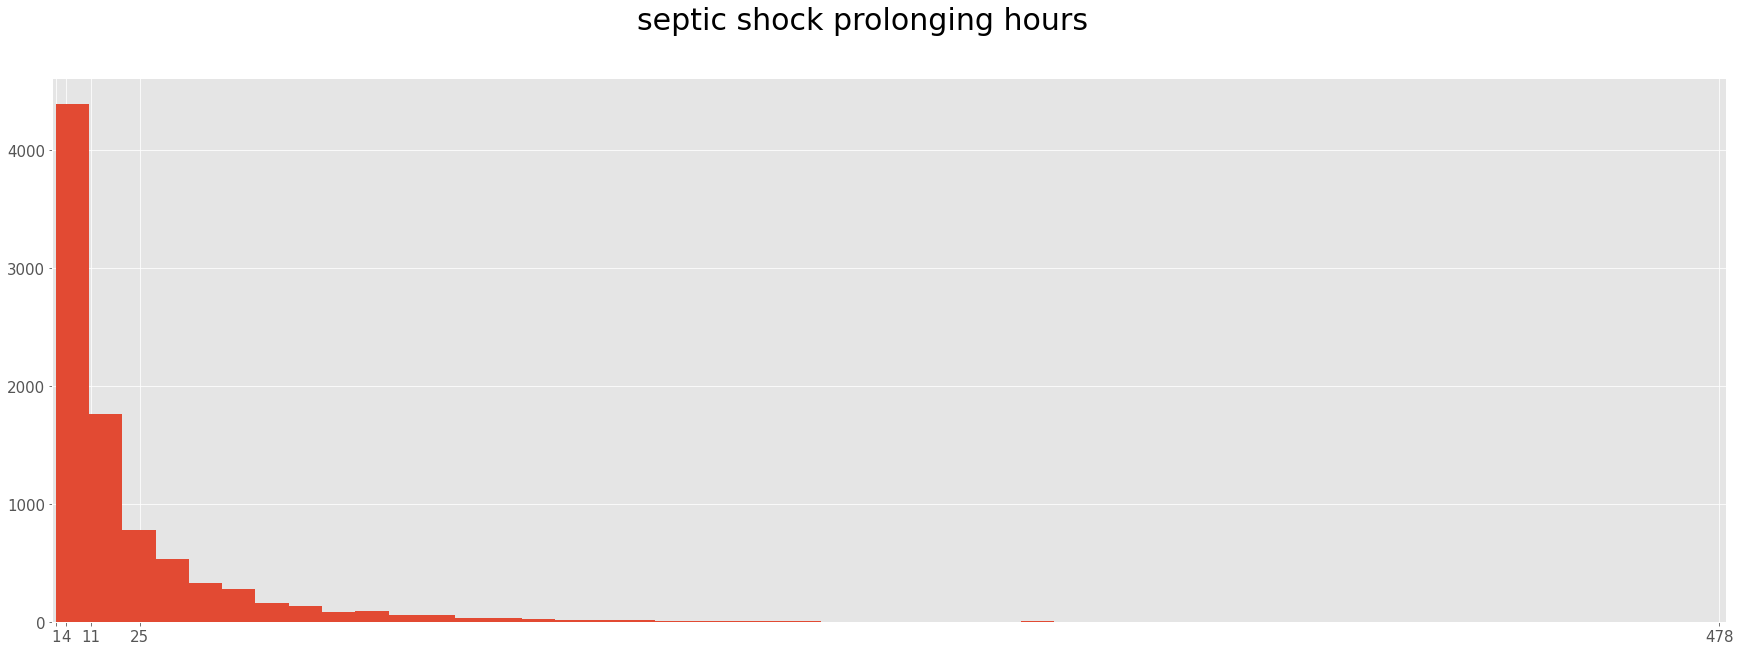

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(30,10))
plt.hist(prl_list, bins=50)
plt.xticks(pd.Series(prl_list).describe(percentiles=np.round(np.arange(0.05, 1, 0.05), 2)).to_numpy()[3::5], size=15)
plt.yticks(size=15)
plt.xlim(0,480)
plt.suptitle('septic shock prolonging hours',size=30)
plt.savefig('shock_prolonging_hrs.pdf')

## 1.4 shock recurrence time check

In [ ]:
def shock_recurrence_time(x, target_col='SHOCK'):
    if x[target_col].sum() == 0:
        return [np.nan]
    else:
        td_list = []
        t_idx = x.index[x[target_col]==1]

        tmp_list = [t_idx[0]]
        for idx in t_idx:
            if (idx - tmp_list[-1]) > 1:
                td_list.append(idx - tmp_list[-1] - 1)
            tmp_list.append(idx)
        
        if len(td_list) == 0:
            return [0]
        else: 
            return td_list

In [ ]:
srt_results = data.loc[data['stay_id'].isin(shock_ids)].groupby('stay_id').apply(shock_recurrence_time).ravel()
srt_list = []
for i in srt_results:
    srt_list += i

In [ ]:
pd.Series(srt_list).describe(percentiles=np.round(np.arange(0.05, 1, 0.05), 2)).to_csv('shock_recurrence_hrs.csv')
pd.Series(srt_list).describe(percentiles=np.round(np.arange(0.05, 1, 0.05), 2))

count    6889.000000
mean       24.437074
std        68.931560
min         0.000000
5%          0.000000
10%         0.000000
15%         0.000000
20%         0.000000
25%         0.000000
30%         0.000000
35%         0.000000
40%         1.000000
45%         2.000000
50%         3.000000
55%         4.000000
60%         6.000000
65%         7.000000
70%        11.000000
75%        15.000000
80%        24.000000
85%        37.000000
90%        64.000000
95%       129.600000
max      1238.000000
dtype: float64

In [ ]:
len([i for i in srt_list if i == 0])

2454

In [ ]:
pd.Series([i for i in srt_list if i != 0]).describe(percentiles=np.round(np.arange(0.05, 1, 0.05), 2)).to_csv('shock_recurrence_hrs_wo0.csv')
pd.Series([i for i in srt_list if i != 0]).describe(percentiles=np.round(np.arange(0.05, 1, 0.05), 2))

count    4435.000000
mean       37.958737
std        82.872991
min         1.000000
5%          1.000000
10%         1.000000
15%         2.000000
20%         2.000000
25%         3.000000
30%         4.000000
35%         5.000000
40%         6.000000
45%         7.000000
50%         9.000000
55%        12.000000
60%        14.000000
65%        18.000000
70%        24.000000
75%        33.000000
80%        46.000000
85%        67.000000
90%       101.000000
95%       177.000000
max      1238.000000
dtype: float64

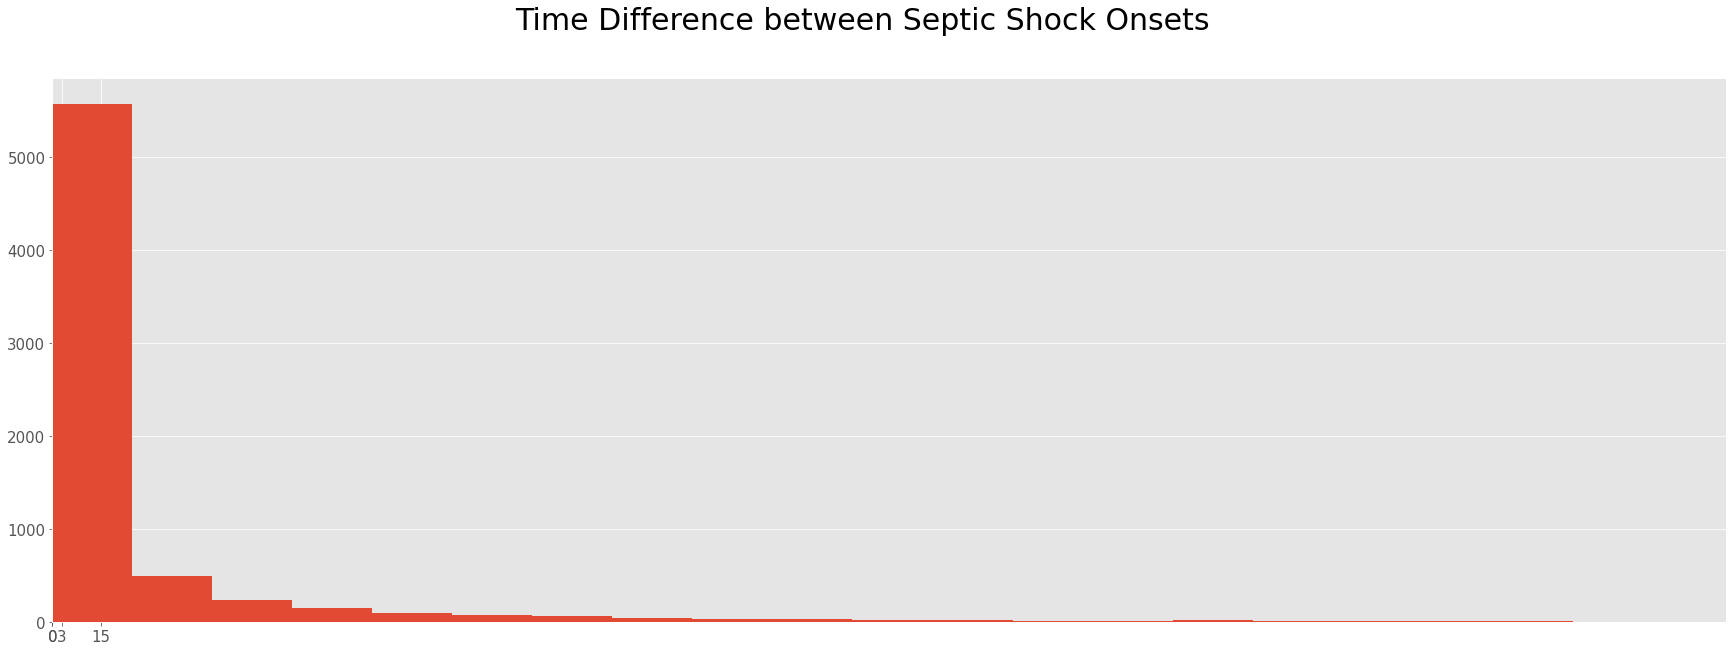

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(30,10))
plt.hist(srt_list, bins=50)
plt.xticks(pd.Series(srt_list).describe(percentiles=np.round(np.arange(0.05, 1, 0.05), 2)).to_numpy()[3::5], size=15)
plt.yticks(size=15)
plt.xlim(0,518)
plt.suptitle('Time Difference between Septic Shock Onsets',size=30)
plt.savefig('shock_recurrence_hrs.pdf')

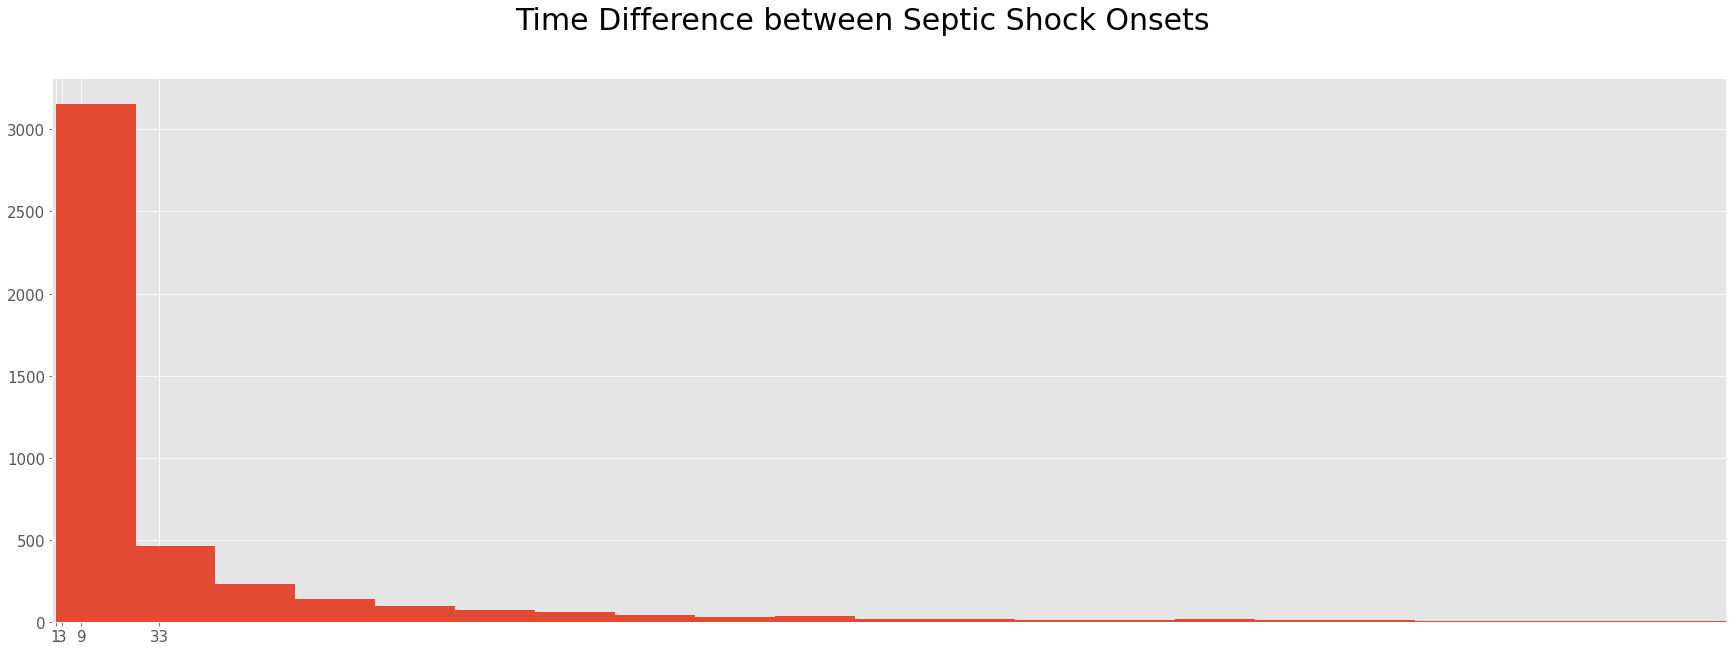

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(30,10))
plt.hist([i for i in srt_list if i != 0], bins=50)
plt.xticks(pd.Series([i for i in srt_list if i != 0]).describe(percentiles=np.round(np.arange(0.05, 1, 0.05), 2)).to_numpy()[3::5], size=15)
plt.yticks(size=15)
plt.xlim(0,518)
plt.suptitle('Time Difference between Septic Shock Onsets',size=30)
plt.savefig('shock_recurrence_hrs_wo0.pdf')

## 1.5 shock의 횟수

In [ ]:
def n_target(x, target_col='SHOCK'):
    target = x[target_col]
    t_idx = target[target==1].index

    if len(t_idx) == 0:
        return 0
    else:
        tmp = np.sort(np.array(t_idx))
        tmp = np.sort(np.array([tmp[0]-1] + list(set(range(tmp[0], tmp[-1]+1)) - set(tmp))+[tmp[-1]+1]))
        tmp = tmp[1:]-tmp[:-1]-1
        tmp = tmp[np.where(tmp>0)]

        return len(tmp)
    
ns_result = data.loc[data['stay_id'].isin(shock_ids)].groupby('stay_id').apply(n_target)

ns_list = []
for i in ns_result:
    ns_list.append(i)

In [ ]:
pd.Series(ns_list).describe(percentiles=np.round(np.arange(0.05, 1, 0.05), 2)).to_csv('n_shock.csv')
pd.Series(ns_list).describe(percentiles=np.round(np.arange(0.05, 1, 0.05), 2))

count    4369.000000
mean        2.015106
std         1.915512
min         1.000000
5%          1.000000
10%         1.000000
15%         1.000000
20%         1.000000
25%         1.000000
30%         1.000000
35%         1.000000
40%         1.000000
45%         1.000000
50%         1.000000
55%         1.000000
60%         2.000000
65%         2.000000
70%         2.000000
75%         2.000000
80%         3.000000
85%         3.000000
90%         4.000000
95%         6.000000
max        28.000000
dtype: float64

# EON